# TESS Atlas fit for TOI 128

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 128.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-128.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-128.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-128.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 128

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 128 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

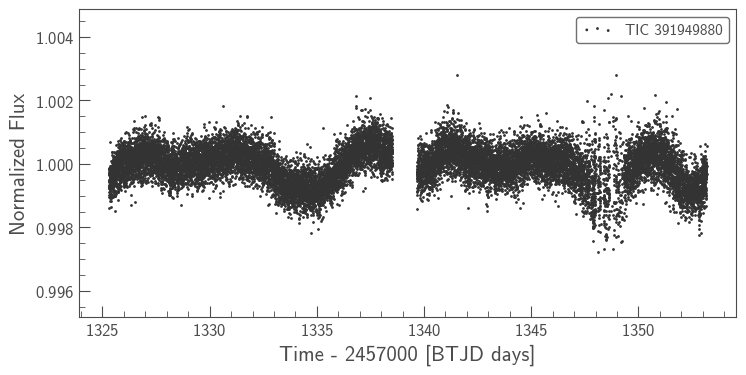

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -21253.580270413062 -> -19351.766764971275


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -12982.848882190678 -> -10312.336893471325


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -10312.336893471327 -> -10235.442117159033


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -10235.442117159033 -> -10235.43743579267


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -10235.43743579267 -> -10232.380778931783


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -10232.380778931783 -> -10232.285544348564


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -10232.285544348564 -> -10229.102808370322


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -10229.102808370324 -> -10229.102808370259


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -10229.102808370257 -> -10229.102808370257


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -10229.102808370257 -> -10229.102808370257


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -10229.102808370257 -> -10229.102808370257


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -10229.102808370257 -> -10229.102808370257


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -10229.102808370257 -> -10229.102808370257


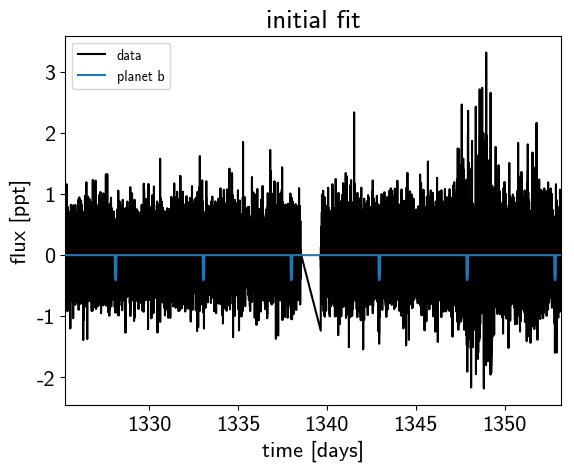

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:08, 11.51draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:09, 10.32draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:24,  3.81draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:25,  3.51draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:22,  3.96draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:27,  3.21draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:32,  2.67draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:25,  3.38draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:33,  2.60draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:30,  2.72draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:29,  2.81draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:27,  2.94draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:21,  3.60draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:26,  2.96draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:23,  3.27draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:23,  3.21draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:25,  3.00draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:22,  3.31draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:08<00:25,  2.92draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:20,  3.46draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:08<00:25,  2.77draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:09<00:24,  2.87draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:10<00:22,  2.92draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:10<00:21,  2.96draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:11<00:20,  3.05draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:12<00:20,  3.03draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:12<00:19,  3.05draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:12<00:15,  3.71draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:13<00:19,  2.92draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:13<00:15,  3.60draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:14<00:18,  2.93draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:14<00:15,  3.51draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:14<00:17,  2.96draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:14<00:15,  3.38draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:15<00:16,  3.08draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:15<00:14,  3.34draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:15<00:16,  3.01draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:16<00:15,  3.18draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:16<00:15,  3.09draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:16<00:15,  2.93draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:17<00:17,  2.64draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:17<00:14,  3.01draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:18<00:16,  2.57draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:18<00:13,  3.13draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:18<00:17,  2.36draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:19<00:13,  3.02draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:19<00:15,  2.56draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:19<00:13,  2.89draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:20<00:14,  2.60draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:20<00:13,  2.77draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:21<00:13,  2.63draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:21<00:12,  2.74draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:21<00:12,  2.64draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:22<00:11,  2.90draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:22<00:11,  2.76draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:22<00:09,  3.06draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:23<00:10,  2.90draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:23<00:08,  3.17draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:23<00:09,  2.92draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:23<00:08,  3.15draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:24<00:09,  2.52draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:24<00:07,  3.01draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:25<00:09,  2.43draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:25<00:07,  3.13draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:26<00:08,  2.52draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:26<00:06,  3.13draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:26<00:07,  2.59draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:27<00:06,  2.71draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:27<00:05,  2.82draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:28<00:04,  2.94draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:29<00:03,  3.00draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:29<00:02,  3.11draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:29<00:02,  3.76draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:30<00:02,  2.61draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:31<00:01,  2.76draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:31<00:01,  2.69draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:31<00:00,  3.06draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:32<00:00,  2.39draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:34<00:01,  1.01s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [00:34<00:00,  2.97draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:06, 13.71draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:00<00:09,  9.64draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:22,  4.11draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:20,  4.41draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:29,  2.99draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:27,  3.24draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:32,  2.67draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:33,  2.56draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:30,  2.77draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:38,  2.19draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:35,  2.29draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:27,  2.98draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:32,  2.45draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:25,  3.12draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:32,  2.38draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:31,  2.39draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:25,  3.00draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:08<00:28,  2.58draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:08<00:25,  2.85draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:27,  2.65draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:09<00:26,  2.71draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:09<00:28,  2.49draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:09<00:23,  2.91draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:10<00:18,  3.67draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:10<00:26,  2.55draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:11<00:22,  2.83draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:11<00:21,  2.92draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:12<00:24,  2.59draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:12<00:19,  3.20draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:12<00:22,  2.65draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:13<00:19,  2.97draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:13<00:22,  2.62draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:13<00:19,  2.98draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:14<00:21,  2.64draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:14<00:17,  3.08draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:14<00:18,  2.91draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:15<00:16,  3.14draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:15<00:17,  2.96draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:15<00:16,  3.09draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:16<00:16,  3.10draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:16<00:16,  3.05draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:16<00:15,  3.18draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:17<00:15,  2.95draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:17<00:14,  3.19draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:17<00:16,  2.69draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:18<00:14,  3.00draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:18<00:13,  3.28draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:18<00:13,  3.00draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:19<00:13,  3.13draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:19<00:14,  2.83draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:20<00:15,  2.51draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:20<00:15,  2.38draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:21<00:11,  3.08draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:21<00:14,  2.37draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:21<00:11,  2.98draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:22<00:13,  2.39draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:22<00:11,  2.91draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:23<00:12,  2.47draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:23<00:10,  2.80draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:24<00:13,  2.15draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:24<00:11,  2.53draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:25<00:12,  2.12draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:25<00:10,  2.47draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:25<00:11,  2.22draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:26<00:09,  2.52draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:26<00:07,  2.98draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:27<00:08,  2.47draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:27<00:06,  3.05draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:27<00:08,  2.32draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:28<00:06,  2.45draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:28<00:05,  2.89draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:29<00:06,  2.27draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:29<00:04,  2.85draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:30<00:06,  2.13draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:30<00:04,  2.64draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:31<00:05,  1.99draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:32<00:04,  2.20draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:32<00:03,  2.47draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:32<00:02,  2.50draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:33<00:02,  2.34draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:34<00:02,  1.85draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:34<00:02,  1.53draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:35<00:01,  1.60draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:35<00:01,  1.89draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:36<00:00,  2.13draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:39<00:00,  1.19s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<02:46,  1.22draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<02:06,  1.60draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:41,  1.98draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:32,  2.15draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:02<01:22,  2.40draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:25,  2.30draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:02<01:16,  2.57draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:03<01:33,  2.09draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:03<01:22,  2.35draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:04<01:38,  1.96draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:04<01:25,  2.25draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:05<01:27,  2.18draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:05<01:13,  2.58draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:06<01:18,  2.40draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:06<01:18,  2.40draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:06<01:12,  2.57draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:06<00:57,  3.25draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:07<01:11,  2.57draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:07<00:58,  3.16draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:07<00:54,  3.36draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:08<00:53,  3.41draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:08<00:42,  4.21draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:09<01:00,  2.97draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:09<00:50,  3.49draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:09<00:53,  3.27draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:10<00:54,  3.23draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:10<00:53,  3.27draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:10<00:40,  4.28draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:11<00:59,  2.88draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:11<00:58,  2.91draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:12<00:53,  3.12draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:12<01:01,  2.70draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:13<00:49,  3.30draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:13<00:41,  3.95draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:13<00:53,  3.07draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:13<00:44,  3.60draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:14<00:44,  3.61draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:14<00:34,  4.56draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:14<00:38,  4.07draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:15<00:43,  3.59draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:15<00:43,  3.59draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:15<00:37,  4.03draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:15<00:31,  4.80draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:16<00:32,  4.66draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:16<00:42,  3.54draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:16<00:33,  4.46draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:17<00:48,  3.02draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:17<00:39,  3.68draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:17<00:44,  3.20draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:18<00:41,  3.41draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:18<00:45,  3.11draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:18<00:43,  3.24draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:19<00:49,  2.85draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:19<00:41,  3.31draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:19<00:36,  3.74draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:20<00:39,  3.44draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:20<00:34,  3.88draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:20<00:34,  3.90draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:20<00:30,  4.32draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:21<00:29,  4.43draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:21<00:39,  3.30draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:21<00:33,  3.84draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:22<00:30,  4.20draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:22<00:24,  5.05draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:22<00:26,  4.75draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:23<00:30,  4.04draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:23<00:27,  4.49draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:24<00:47,  2.55draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:24<00:46,  2.58draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:25<00:40,  2.95draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:25<00:46,  2.51draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:25<00:36,  3.20draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:26<00:35,  3.23draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:26<00:39,  2.88draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:26<00:31,  3.59draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:26<00:26,  4.26draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:27<00:27,  4.02draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:27<00:29,  3.71draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:27<00:26,  4.11draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:28<00:34,  3.03draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:28<00:28,  3.70draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:28<00:19,  5.06draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:29<00:22,  4.39draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:29<00:21,  4.53draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:30<00:32,  2.95draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:31<00:32,  2.90draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:31<00:26,  3.57draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:31<00:33,  2.78draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:31<00:24,  3.74draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:32<00:22,  3.90draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:32<00:25,  3.43draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:32<00:24,  3.57draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:33<00:27,  3.15draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:33<00:24,  3.40draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:33<00:28,  2.94draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:33<00:22,  3.66draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:34<00:19,  4.04draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:34<00:16,  4.73draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:35<00:25,  3.06draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:36<00:24,  3.01draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:36<00:24,  3.00draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:36<00:24,  2.92draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:37<00:24,  2.90draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:37<00:23,  2.99draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:37<00:27,  2.53draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:38<00:22,  3.03draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:38<00:25,  2.64draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:38<00:19,  3.37draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:39<00:23,  2.77draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:39<00:20,  3.08draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:39<00:21,  2.91draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:40<00:20,  2.97draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:40<00:20,  2.92draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:40<00:17,  3.50draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:40<00:15,  3.92draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:41<00:13,  4.17draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:41<00:17,  3.17draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:41<00:14,  3.73draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:41<00:12,  4.43draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:42<00:11,  4.87draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:42<00:10,  5.17draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:42<00:13,  3.98draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:42<00:14,  3.62draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:43<00:11,  4.43draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:43<00:09,  5.18draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:43<00:09,  4.93draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:43<00:10,  4.58draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:44<00:10,  4.38draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:44<00:08,  5.33draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:44<00:08,  5.21draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:45<00:13,  3.05draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:45<00:10,  3.74draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:45<00:12,  3.24draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:46<00:12,  2.99draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:46<00:12,  2.93draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:46<00:11,  3.07draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:47<00:14,  2.49draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:47<00:09,  3.32draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:47<00:08,  3.88draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:48<00:11,  2.72draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:48<00:09,  2.96draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:49<00:09,  2.96draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:49<00:07,  3.22draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:50<00:06,  3.58draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:50<00:06,  3.55draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:50<00:05,  4.07draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:51<00:06,  3.07draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:51<00:05,  3.86draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:51<00:07,  2.66draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:52<00:06,  2.84draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:52<00:05,  2.92draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:52<00:04,  3.70draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:53<00:05,  2.67draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:53<00:04,  2.80draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:54<00:05,  2.20draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:54<00:04,  2.30draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:55<00:04,  1.97draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:56<00:04,  1.78draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:57<00:04,  1.67draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:57<00:03,  1.59draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:58<00:03,  1.52draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:59<00:02,  1.46draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:59<00:02,  1.42draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:00<00:01,  1.40draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:00<00:00,  1.81draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:01<00:00,  2.11draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:13, 30.09draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:16, 24.70draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:00<00:13, 28.10draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:00<00:14, 27.69draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:00<00:13, 28.19draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:00<00:12, 31.23draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:00<00:12, 30.63draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:01<00:13, 26.86draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:01<00:16, 22.59draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:01<00:14, 25.74draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:01<00:12, 28.07draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:01<00:11, 31.35draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:01<00:13, 26.07draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:01<00:12, 28.65draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:02<00:11, 30.75draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:02<00:10, 32.76draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:02<00:09, 34.09draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:02<00:09, 33.60draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:02<00:09, 33.82draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:02<00:09, 33.14draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:02<00:10, 30.70draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:02<00:10, 30.97draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:03<00:11, 27.16draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:03<00:10, 28.53draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:03<00:11, 25.90draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:03<00:15, 19.12draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:03<00:17, 16.49draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:04<00:18, 16.25draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:04<00:18, 15.65draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:04<00:21, 13.54draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:04<00:21, 13.19draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:04<00:17, 16.21draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:04<00:15, 18.33draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:04<00:13, 19.98draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:05<00:15, 17.11draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:05<00:13, 19.30draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:05<00:11, 22.60draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:05<00:10, 23.83draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:05<00:11, 23.37draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:05<00:10, 24.68draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:05<00:10, 24.53draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:06<00:09, 25.16draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:06<00:09, 26.28draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:06<00:09, 25.32draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:06<00:09, 26.00draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:06<00:08, 26.70draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:06<00:07, 29.35draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:06<00:06, 33.13draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:06<00:06, 34.68draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:07<00:06, 35.64draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:07<00:06, 33.81draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:07<00:05, 35.01draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:07<00:05, 35.09draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:07<00:05, 37.17draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:07<00:05, 36.40draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:07<00:05, 37.14draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:07<00:05, 34.09draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:07<00:05, 34.17draws/s]

Sampling 2 chains:  56%|█████▌    | 225/404 [00:08<00:05, 33.88draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:08<00:04, 37.14draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:08<00:04, 36.28draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:08<00:04, 36.03draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:08<00:04, 37.77draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:08<00:03, 41.12draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:08<00:03, 39.49draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:09<00:03, 37.71draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:09<00:03, 35.85draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:09<00:03, 36.23draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:09<00:04, 30.18draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:09<00:04, 26.83draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:09<00:04, 26.29draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:09<00:04, 24.62draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:10<00:04, 25.92draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:10<00:03, 29.66draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:10<00:03, 33.07draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:10<00:02, 37.54draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:10<00:02, 39.60draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:10<00:02, 39.37draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:10<00:01, 43.12draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:10<00:01, 40.07draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:11<00:02, 33.50draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:11<00:02, 25.75draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:11<00:02, 25.95draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:11<00:02, 25.93draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [00:11<00:02, 27.91draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:11<00:01, 28.15draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:12<00:06,  8.41draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [00:13<00:07,  6.46draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:13<00:07,  6.05draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [00:14<00:06,  6.83draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:14<00:06,  7.08draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:14<00:04,  8.62draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:14<00:03,  9.92draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:14<00:03, 11.08draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:14<00:02, 12.75draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:14<00:02, 12.56draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:15<00:02, 13.30draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:15<00:01, 15.05draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:15<00:01, 14.47draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:15<00:01, 14.65draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:15<00:01, 16.10draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:16<00:01, 10.93draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:16<00:01, 12.06draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:16<00:01, 13.55draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:16<00:00, 14.69draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:16<00:00, 16.98draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:16<00:00, 18.12draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:16<00:00, 20.26draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:16<00:00, 23.95draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:28, 27.92draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:27, 28.84draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:29, 27.25draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:00<00:27, 28.58draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:00<00:26, 29.65draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:00<00:30, 25.91draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:00<00:32, 24.08draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:01<00:30, 25.64draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:01<00:27, 28.44draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:01<00:33, 23.02draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:01<00:30, 24.81draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:01<00:29, 25.46draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:01<00:28, 26.72draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:01<00:24, 30.62draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:02<00:23, 31.96draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:02<00:24, 30.20draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:02<00:22, 32.20draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:02<00:20, 35.47draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:02<00:18, 38.24draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:02<00:24, 29.03draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:03<00:27, 26.06draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:03<00:26, 27.13draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:03<00:24, 29.26draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:03<00:24, 28.97draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:03<00:21, 31.82draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:03<00:23, 30.09draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:03<00:23, 30.02draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:03<00:22, 30.44draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:04<00:22, 30.90draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:04<00:21, 31.73draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:04<00:23, 28.78draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:04<00:20, 32.03draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:04<00:20, 32.33draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:04<00:20, 31.92draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:04<00:22, 28.91draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:05<00:21, 30.29draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:05<00:19, 32.90draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:05<00:17, 36.01draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:05<00:19, 32.21draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:05<00:19, 32.63draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:05<00:18, 33.67draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:05<00:16, 37.29draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:05<00:16, 37.92draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:05<00:15, 40.81draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:06<00:15, 40.23draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:06<00:14, 42.61draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:06<00:13, 42.79draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:06<00:13, 42.83draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:06<00:12, 45.52draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:06<00:12, 46.22draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:06<00:12, 46.89draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:06<00:10, 51.95draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:07<00:11, 49.55draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:07<00:12, 45.57draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [00:07<00:12, 44.58draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:07<00:11, 46.84draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [00:07<00:11, 48.39draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [00:07<00:10, 48.76draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [00:07<00:13, 39.99draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:07<00:12, 41.59draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:08<00:11, 46.83draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:08<00:10, 48.70draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:08<00:10, 46.98draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [00:08<00:11, 44.76draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:08<00:11, 44.08draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:08<00:13, 35.81draws/s]

Sampling 2 chains:  40%|███▉      | 321/804 [00:08<00:12, 39.53draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:09<00:12, 37.83draws/s]

Sampling 2 chains:  41%|████      | 331/804 [00:09<00:12, 38.72draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [00:09<00:11, 41.04draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:09<00:09, 48.05draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [00:09<00:08, 51.62draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:09<00:08, 53.15draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [00:09<00:08, 51.49draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [00:09<00:08, 52.74draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:09<00:08, 50.50draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:10<00:08, 50.01draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:10<00:08, 49.68draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:10<00:08, 50.04draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [00:10<00:07, 53.43draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [00:10<00:07, 50.09draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:10<00:07, 50.26draws/s]

Sampling 2 chains:  52%|█████▏    | 419/804 [00:10<00:08, 45.97draws/s]

Sampling 2 chains:  53%|█████▎    | 424/804 [00:11<00:10, 36.44draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:11<00:09, 38.05draws/s]

Sampling 2 chains:  54%|█████▍    | 436/804 [00:11<00:08, 42.80draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:11<00:08, 40.84draws/s]

Sampling 2 chains:  55%|█████▌    | 446/804 [00:11<00:08, 40.16draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:11<00:10, 34.92draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [00:11<00:10, 33.72draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:11<00:09, 34.64draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:12<00:09, 35.98draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [00:12<00:09, 34.54draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [00:12<00:11, 28.74draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [00:12<00:12, 27.32draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [00:12<00:11, 29.05draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:12<00:10, 30.38draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:12<00:09, 34.36draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:13<00:08, 35.33draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:13<00:08, 36.59draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:13<00:09, 32.64draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [00:13<00:08, 34.39draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [00:13<00:08, 36.47draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [00:13<00:07, 39.82draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [00:13<00:06, 42.99draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [00:13<00:06, 42.94draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [00:14<00:06, 40.34draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:14<00:06, 41.93draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [00:14<00:06, 42.71draws/s]

Sampling 2 chains:  69%|██████▊   | 551/804 [00:14<00:06, 39.22draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:14<00:05, 41.29draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:14<00:05, 45.06draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:14<00:05, 43.45draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [00:14<00:04, 46.97draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [00:15<00:04, 48.07draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [00:15<00:04, 46.21draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:15<00:04, 47.00draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [00:15<00:04, 45.46draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [00:15<00:04, 48.52draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:15<00:04, 45.16draws/s]

Sampling 2 chains:  76%|███████▋  | 614/804 [00:15<00:05, 36.43draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [00:16<00:05, 32.42draws/s]

Sampling 2 chains:  77%|███████▋  | 622/804 [00:16<00:07, 24.40draws/s]

Sampling 2 chains:  78%|███████▊  | 626/804 [00:16<00:06, 25.85draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [00:16<00:08, 21.44draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:16<00:07, 24.38draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:16<00:07, 23.47draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [00:16<00:06, 25.27draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [00:17<00:06, 23.86draws/s]

Sampling 2 chains:  80%|████████  | 646/804 [00:17<00:07, 22.10draws/s]

Sampling 2 chains:  81%|████████  | 649/804 [00:17<00:07, 19.80draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [00:17<00:06, 21.98draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:17<00:05, 24.83draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:17<00:05, 24.91draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [00:17<00:04, 28.81draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [00:18<00:04, 31.31draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [00:18<00:03, 32.86draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:18<00:03, 35.42draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:18<00:03, 37.09draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [00:18<00:03, 35.21draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:18<00:02, 38.45draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [00:18<00:02, 42.91draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [00:18<00:02, 47.63draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [00:18<00:01, 46.41draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:19<00:01, 47.60draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [00:19<00:01, 47.04draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [00:19<00:01, 47.17draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [00:19<00:01, 47.84draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:19<00:01, 45.21draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [00:19<00:01, 42.99draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [00:19<00:01, 43.75draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [00:19<00:01, 44.67draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:20<00:01, 39.63draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [00:20<00:01, 37.22draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:20<00:00, 37.26draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [00:20<00:00, 36.95draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:20<00:00, 30.59draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [00:20<00:00, 25.48draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:21<00:00, 23.44draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [00:21<00:00, 22.36draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:21<00:00, 16.94draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:21<00:00, 16.37draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [00:21<00:00, 17.17draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [00:21<00:00, 18.21draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [00:21<00:00, 18.36draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [00:22<00:00, 19.32draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:22<00:00, 36.14draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<03:21, 21.88draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<02:59, 24.55draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:00<03:29, 20.97draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:00<03:20, 21.93draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<03:14, 22.58draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:00<03:10, 23.05draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:00<03:03, 23.82draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:01<02:48, 26.04draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:01<02:45, 26.47draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:01<02:41, 27.15draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:01<02:34, 28.23draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:01<02:22, 30.67draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:01<02:04, 35.04draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:01<01:54, 38.12draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:01<01:51, 39.11draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:01<01:49, 39.81draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:02<01:47, 40.28draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:02<01:47, 40.24draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:02<01:40, 43.00draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:02<01:55, 37.39draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:02<02:29, 28.85draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:02<02:46, 25.93draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:03<03:21, 21.44draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:03<03:24, 21.02draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:03<03:18, 21.67draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:03<02:51, 25.06draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:03<02:48, 25.55draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:03<02:51, 25.01draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:03<02:36, 27.37draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:03<02:38, 27.09draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:04<02:38, 27.06draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:04<02:17, 31.16draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:04<02:10, 32.87draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:04<02:04, 34.36draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:04<01:50, 38.44draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:04<01:47, 39.75draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:04<01:39, 42.68draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:05<02:34, 27.55draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:05<02:32, 27.86draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:05<02:28, 28.60draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:05<03:20, 21.09draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:05<03:51, 18.27draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:06<04:11, 16.80draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:06<03:53, 18.15draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:06<04:19, 16.27draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:06<04:02, 17.43draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:06<04:08, 16.97draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:06<04:13, 16.63draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:06<04:13, 16.60draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:07<03:55, 17.87draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:07<03:35, 19.51draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:07<03:57, 17.75draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:07<04:48, 14.57draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:07<04:33, 15.36draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:08<06:42, 10.44draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:08<06:28, 10.82draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:08<06:34, 10.64draws/s]

Sampling 2 chains:   5%|▍         | 209/4404 [00:08<06:45, 10.34draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:08<07:07,  9.81draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:09<06:17, 11.10draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:09<06:15, 11.16draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:09<05:15, 13.24draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:09<05:17, 13.17draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:09<04:30, 15.47draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:09<04:49, 14.44draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:09<04:41, 14.86draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:09<04:29, 15.50draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:10<03:45, 18.50draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:10<03:13, 21.53draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:10<03:21, 20.69draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:10<03:10, 21.79draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:10<02:41, 25.66draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:10<02:44, 25.19draws/s]

Sampling 2 chains:   6%|▌         | 257/4404 [00:10<02:31, 27.29draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:11<03:56, 17.54draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:11<04:54, 14.07draws/s]

Sampling 2 chains:   6%|▌         | 265/4404 [00:11<05:14, 13.15draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:11<04:41, 14.71draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:11<04:34, 15.06draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:12<04:20, 15.83draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:12<04:34, 15.02draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:12<04:26, 15.50draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:12<04:15, 16.16draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:12<04:07, 16.63draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:12<04:28, 15.33draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [00:12<03:43, 18.42draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:13<03:31, 19.44draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:13<03:26, 19.93draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:13<03:04, 22.24draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:13<02:54, 23.51draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:13<03:05, 22.11draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:13<02:53, 23.59draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:13<02:59, 22.76draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:13<03:04, 22.23draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:14<03:09, 21.52draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:14<03:12, 21.26draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:14<02:58, 22.93draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:14<03:06, 21.90draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:14<02:58, 22.83draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:14<02:39, 25.46draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:14<02:33, 26.46draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:14<02:29, 27.26draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:15<02:55, 23.16draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:15<03:12, 21.12draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:15<03:00, 22.52draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:15<03:02, 22.24draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:15<02:55, 23.14draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:15<02:57, 22.86draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:15<03:04, 21.93draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:16<02:58, 22.58draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:16<03:33, 18.95draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:16<03:37, 18.56draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:16<03:22, 19.92draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [00:16<02:52, 23.41draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:16<02:38, 25.40draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [00:16<02:39, 25.16draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:17<02:41, 24.94draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:17<02:34, 25.99draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [00:17<02:45, 24.29draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:17<02:56, 22.68draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:17<02:43, 24.44draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [00:17<02:27, 27.16draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:17<02:10, 30.69draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:17<01:58, 33.76draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:18<01:50, 36.08draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:18<01:50, 35.96draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:18<01:56, 34.16draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:18<01:52, 35.18draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:18<02:31, 26.27draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [00:18<02:59, 22.07draws/s]

Sampling 2 chains:  10%|█         | 441/4404 [00:19<02:53, 22.84draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:19<02:52, 22.99draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [00:19<03:01, 21.77draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [00:19<03:21, 19.66draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [00:19<03:58, 16.59draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:19<03:34, 18.38draws/s]

Sampling 2 chains:  10%|█         | 460/4404 [00:20<03:13, 20.33draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:20<03:07, 20.99draws/s]

Sampling 2 chains:  11%|█         | 468/4404 [00:20<02:49, 23.21draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:20<02:26, 26.83draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:20<02:21, 27.81draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:20<02:09, 30.31draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:20<01:57, 33.27draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:20<02:17, 28.47draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:21<02:34, 25.26draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:21<02:23, 27.13draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:21<02:23, 27.25draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:21<02:20, 27.69draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [00:21<02:28, 26.32draws/s]

Sampling 2 chains:  12%|█▏        | 510/4404 [00:21<02:46, 23.39draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:21<02:48, 23.15draws/s]

Sampling 2 chains:  12%|█▏        | 520/4404 [00:22<02:28, 26.16draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [00:22<02:32, 25.40draws/s]

Sampling 2 chains:  12%|█▏        | 526/4404 [00:22<02:36, 24.79draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:22<02:30, 25.83draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:22<02:26, 26.47draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:22<02:51, 22.54draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [00:22<02:45, 23.29draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:23<02:28, 26.08draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [00:23<02:14, 28.73draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:23<02:34, 24.89draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:23<02:35, 24.77draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [00:23<03:06, 20.59draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [00:23<03:00, 21.31draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [00:23<02:36, 24.49draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:24<03:10, 20.09draws/s]

Sampling 2 chains:  13%|█▎        | 571/4404 [00:24<03:00, 21.29draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:24<02:45, 23.17draws/s]

Sampling 2 chains:  13%|█▎        | 577/4404 [00:24<02:42, 23.55draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [00:24<02:35, 24.62draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [00:24<02:28, 25.68draws/s]

Sampling 2 chains:  13%|█▎        | 586/4404 [00:24<02:47, 22.84draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:25<03:02, 20.90draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [00:25<03:16, 19.42draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:25<03:12, 19.75draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [00:25<02:56, 21.60draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:25<02:49, 22.38draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [00:25<02:39, 23.90draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [00:25<02:54, 21.71draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [00:25<02:43, 23.15draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [00:26<02:29, 25.29draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [00:26<02:37, 24.08draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [00:26<03:04, 20.47draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:26<03:23, 18.61draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [00:26<03:01, 20.85draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [00:26<02:52, 21.83draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [00:27<02:50, 22.18draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [00:27<02:55, 21.47draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:27<02:40, 23.45draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [00:27<02:32, 24.65draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [00:27<02:26, 25.68draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:27<02:32, 24.62draws/s]

Sampling 2 chains:  15%|█▍        | 653/4404 [00:27<02:35, 24.11draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [00:27<02:34, 24.21draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [00:28<02:51, 21.88draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [00:28<02:47, 22.37draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [00:28<02:25, 25.66draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [00:28<02:27, 25.34draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [00:28<02:16, 27.38draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:28<02:19, 26.74draws/s]

Sampling 2 chains:  15%|█▌        | 681/4404 [00:28<02:13, 27.88draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [00:29<02:29, 24.93draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [00:29<02:37, 23.65draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [00:29<02:47, 22.20draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [00:29<02:44, 22.61draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [00:29<02:34, 24.02draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:29<02:34, 23.95draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [00:29<02:38, 23.42draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [00:29<02:44, 22.49draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [00:30<02:50, 21.72draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [00:30<03:41, 16.69draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:30<03:23, 18.14draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:30<03:28, 17.71draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:30<03:06, 19.75draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [00:30<02:39, 23.01draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:31<02:35, 23.68draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [00:31<02:39, 23.09draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [00:31<02:20, 26.10draws/s]

Sampling 2 chains:  17%|█▋        | 738/4404 [00:31<02:09, 28.32draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [00:31<02:20, 26.03draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [00:31<02:20, 25.96draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [00:31<02:14, 27.23draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [00:31<02:09, 28.16draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [00:32<02:10, 27.97draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:32<02:25, 25.02draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:32<02:27, 24.76draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:32<02:22, 25.46draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [00:32<02:11, 27.62draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [00:32<02:13, 27.15draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [00:32<02:17, 26.31draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [00:32<02:09, 27.96draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [00:33<02:07, 28.33draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [00:33<02:06, 28.71draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [00:33<02:07, 28.39draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [00:33<02:09, 27.86draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [00:33<02:01, 29.58draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [00:33<01:50, 32.44draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [00:33<02:00, 29.86draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [00:33<01:54, 31.48draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:34<01:59, 29.95draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [00:34<01:58, 30.25draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [00:34<01:49, 32.79draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [00:34<01:41, 35.15draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [00:34<01:32, 38.45draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [00:34<01:25, 41.60draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [00:34<01:26, 41.19draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [00:34<01:27, 40.58draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [00:35<01:28, 40.26draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [00:35<01:20, 44.11draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [00:35<01:16, 46.05draws/s]

Sampling 2 chains:  20%|█▉        | 875/4404 [00:35<01:16, 46.34draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [00:35<01:17, 45.70draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [00:35<01:18, 44.72draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [00:35<01:22, 42.71draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [00:35<01:19, 44.22draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [00:36<01:22, 42.47draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [00:36<01:25, 41.01draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [00:36<01:32, 37.67draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [00:36<01:33, 37.20draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [00:36<01:45, 32.91draws/s]

Sampling 2 chains:  21%|██        | 924/4404 [00:36<01:47, 32.41draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [00:36<01:39, 34.87draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [00:36<01:27, 39.79draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [00:37<01:27, 39.40draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [00:37<01:24, 40.72draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [00:37<01:17, 44.78draws/s]

Sampling 2 chains:  22%|██▏       | 956/4404 [00:37<01:21, 42.34draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:37<01:26, 39.78draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [00:37<01:18, 43.73draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [00:37<01:10, 48.35draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [00:37<01:09, 49.25draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [00:38<01:08, 49.74draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [00:38<01:10, 48.64draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [00:38<01:11, 47.64draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [00:38<01:24, 40.29draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [00:38<01:32, 36.66draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [00:38<01:36, 35.24draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [00:38<01:40, 33.63draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [00:39<02:02, 27.73draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [00:39<02:27, 22.94draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [00:39<02:11, 25.64draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [00:39<02:13, 25.27draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [00:39<02:14, 25.03draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [00:39<02:11, 25.70draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [00:39<02:06, 26.64draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [00:40<02:10, 25.73draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [00:40<02:01, 27.55draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [00:40<02:01, 27.54draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [00:40<01:59, 28.11draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [00:40<01:54, 29.30draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [00:40<01:43, 32.23draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [00:40<01:54, 29.20draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [00:40<01:55, 28.80draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [00:41<01:55, 28.91draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [00:41<02:01, 27.35draws/s]

Sampling 2 chains:  25%|██▍       | 1080/4404 [00:41<02:01, 27.40draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [00:41<01:59, 27.69draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [00:41<01:48, 30.63draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [00:41<01:37, 33.96draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [00:41<01:29, 37.00draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [00:41<01:16, 43.05draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [00:41<01:11, 45.86draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [00:42<01:10, 46.62draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [00:42<01:06, 49.17draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [00:42<01:03, 51.48draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [00:42<01:01, 52.71draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [00:42<01:00, 53.69draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [00:42<01:02, 51.80draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [00:42<00:59, 54.55draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [00:42<01:01, 52.83draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [00:43<01:04, 49.86draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [00:43<01:05, 49.69draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [00:43<01:01, 52.03draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [00:43<01:02, 51.48draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [00:43<01:04, 49.92draws/s]

Sampling 2 chains:  27%|██▋       | 1197/4404 [00:43<01:05, 48.82draws/s]

Sampling 2 chains:  27%|██▋       | 1203/4404 [00:43<01:02, 51.08draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [00:43<01:06, 48.32draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [00:44<01:03, 50.30draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [00:44<01:02, 50.71draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [00:44<01:03, 49.80draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [00:44<01:05, 48.26draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [00:44<01:09, 45.77draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [00:44<01:14, 42.67draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [00:44<01:30, 34.76draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [00:45<01:46, 29.62draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [00:45<01:46, 29.61draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [00:45<01:47, 29.29draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [00:45<01:42, 30.74draws/s]

Sampling 2 chains:  29%|██▉       | 1268/4404 [00:45<01:38, 31.99draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [00:45<01:29, 34.83draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [00:45<01:26, 36.02draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [00:45<01:24, 36.92draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [00:45<01:18, 39.81draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [00:46<01:14, 42.00draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [00:46<01:12, 42.79draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [00:46<01:12, 42.78draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [00:46<01:11, 43.36draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [00:46<01:09, 44.68draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [00:46<01:12, 42.81draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [00:46<01:08, 44.84draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [00:46<01:08, 45.02draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [00:47<01:12, 42.33draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [00:47<01:13, 41.56draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [00:47<01:09, 44.02draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [00:47<01:09, 43.82draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [00:47<01:08, 44.15draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [00:47<01:16, 39.73draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [00:47<01:13, 41.41draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [00:47<01:12, 41.94draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [00:48<01:08, 44.38draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [00:48<01:03, 47.16draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [00:48<01:03, 47.09draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [00:48<01:03, 47.48draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [00:48<01:11, 41.81draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [00:48<01:18, 38.16draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [00:48<01:17, 38.69draws/s]

Sampling 2 chains:  32%|███▏      | 1416/4404 [00:48<01:21, 36.86draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [00:49<01:19, 37.56draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [00:49<01:16, 39.02draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [00:49<01:11, 41.70draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [00:49<01:09, 42.59draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [00:49<01:13, 40.46draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [00:49<01:10, 42.23draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [00:49<01:03, 46.31draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [00:49<01:06, 44.14draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [00:50<01:06, 44.51draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [00:50<01:01, 47.78draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [00:50<01:03, 46.26draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [00:50<01:04, 45.05draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [00:50<01:09, 42.11draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [00:50<01:14, 38.89draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [00:50<01:14, 38.96draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [00:50<01:27, 33.15draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [00:51<01:28, 32.91draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [00:51<01:28, 32.64draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [00:51<01:24, 34.24draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [00:51<01:29, 32.34draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [00:51<01:24, 34.06draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [00:51<01:22, 34.79draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [00:51<01:24, 34.02draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [00:51<01:25, 33.80draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [00:52<01:21, 35.36draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [00:52<01:14, 38.39draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [00:52<01:11, 39.74draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [00:52<01:10, 40.21draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [00:52<01:05, 43.18draws/s]

Sampling 2 chains:  35%|███▌      | 1562/4404 [00:52<01:07, 42.34draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [00:52<01:05, 43.44draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [00:52<01:03, 44.31draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [00:52<01:03, 44.64draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [00:53<01:05, 43.36draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [00:53<01:00, 46.49draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [00:53<01:04, 43.25draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [00:53<01:02, 45.03draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [00:53<00:57, 48.41draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [00:53<00:55, 50.10draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [00:53<00:57, 48.28draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [00:53<01:05, 42.60draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [00:54<01:03, 43.45draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [00:54<01:00, 45.91draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [00:54<01:01, 44.70draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [00:54<01:02, 44.00draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [00:54<01:00, 45.82draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [00:54<00:58, 46.90draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [00:54<01:03, 42.85draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [00:54<01:06, 40.98draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [00:55<01:06, 40.97draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [00:55<01:04, 42.00draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [00:55<01:05, 41.54draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [00:55<01:02, 43.44draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [00:55<00:59, 45.90draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [00:55<00:57, 46.89draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [00:55<00:59, 45.07draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [00:55<01:04, 41.59draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [00:56<01:10, 37.90draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [00:56<01:08, 39.11draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [00:56<01:08, 38.90draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [00:56<01:16, 35.02draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [00:56<01:09, 38.43draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [00:56<01:09, 38.11draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [00:56<01:10, 37.96draws/s]

Sampling 2 chains:  40%|███▉      | 1749/4404 [00:56<01:08, 38.80draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [00:57<01:06, 39.94draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [00:57<00:58, 45.30draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [00:57<00:58, 45.36draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [00:57<00:58, 44.83draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [00:57<00:58, 45.30draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [00:57<00:54, 47.87draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [00:57<00:53, 48.83draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [00:57<00:55, 46.84draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [00:57<00:56, 46.15draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [00:58<00:54, 47.31draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [00:58<00:57, 45.22draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [00:58<00:57, 45.09draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [00:58<00:54, 47.42draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [00:58<00:54, 47.24draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [00:58<00:52, 48.84draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [00:58<00:49, 51.79draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [00:58<00:51, 49.23draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [00:59<00:49, 51.54draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [00:59<00:49, 50.97draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [00:59<00:49, 51.53draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [00:59<00:49, 51.09draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [00:59<00:50, 50.26draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [00:59<00:50, 49.98draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [00:59<00:50, 50.22draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [00:59<00:46, 53.40draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [01:00<00:46, 53.86draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [01:00<00:48, 51.99draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [01:00<00:49, 50.44draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [01:00<00:58, 42.22draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [01:00<01:06, 37.39draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [01:00<01:17, 32.02draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [01:00<01:13, 33.63draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [01:01<01:05, 37.69draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [01:01<01:11, 34.33draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [01:01<01:08, 35.65draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [01:01<01:09, 35.18draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [01:01<01:07, 36.23draws/s]

Sampling 2 chains:  45%|████▍     | 1963/4404 [01:01<01:03, 38.38draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [01:01<01:09, 35.11draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [01:01<01:03, 38.09draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [01:02<01:05, 36.91draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [01:02<00:59, 40.59draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [01:02<00:56, 42.50draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [01:02<00:58, 41.29draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [01:02<00:56, 42.95draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [01:02<00:54, 43.95draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [01:02<00:57, 41.48draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [01:02<00:55, 43.18draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [01:02<00:54, 43.61draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [01:03<00:58, 40.39draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [01:03<00:57, 41.20draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [01:03<00:54, 43.42draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [01:03<00:52, 44.75draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [01:03<00:51, 45.91draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [01:03<00:52, 45.06draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [01:03<00:52, 45.10draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [01:03<00:50, 46.19draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [01:04<00:52, 44.35draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [01:04<00:55, 41.99draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [01:04<00:50, 46.06draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [01:04<00:51, 45.07draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [01:04<00:50, 46.26draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [01:04<00:46, 49.27draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [01:04<00:46, 49.98draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [01:04<00:45, 50.56draws/s]

Sampling 2 chains:  48%|████▊     | 2110/4404 [01:04<00:47, 48.64draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [01:05<00:41, 54.73draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [01:05<00:40, 56.11draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [01:05<00:40, 56.21draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [01:05<00:42, 52.80draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [01:05<00:43, 52.17draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [01:05<00:44, 50.72draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [01:05<00:45, 49.94draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [01:05<00:44, 49.90draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [01:06<00:45, 49.45draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [01:06<00:49, 45.38draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [01:06<00:48, 45.95draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [01:06<00:45, 49.04draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [01:06<00:47, 46.40draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [01:06<00:46, 47.19draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [01:06<00:48, 45.42draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [01:06<00:55, 39.66draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [01:07<00:54, 40.45draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [01:07<00:54, 40.47draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [01:07<00:48, 44.63draws/s]

Sampling 2 chains:  51%|█████     | 2226/4404 [01:07<00:47, 45.45draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [01:07<00:48, 44.81draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [01:07<00:50, 43.02draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [01:07<00:47, 45.23draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [01:07<00:54, 39.67draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [01:08<00:56, 38.09draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [01:08<01:03, 33.64draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [01:08<01:05, 32.94draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [01:08<01:02, 34.04draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [01:08<00:59, 35.71draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [01:08<00:57, 36.95draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [01:08<00:53, 39.90draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [01:09<00:59, 35.82draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [01:09<00:59, 35.26draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [01:09<00:55, 37.77draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [01:09<00:58, 35.91draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [01:09<00:56, 37.14draws/s]

Sampling 2 chains:  52%|█████▏    | 2311/4404 [01:09<00:51, 40.56draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [01:09<00:50, 41.24draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [01:09<00:51, 40.29draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [01:09<00:47, 43.49draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [01:10<00:46, 44.07draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [01:10<00:44, 46.45draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [01:10<00:48, 42.51draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [01:10<00:48, 42.80draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [01:10<00:48, 42.58draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [01:10<00:48, 42.40draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [01:10<00:47, 42.51draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [01:10<00:47, 42.41draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [01:11<00:46, 43.83draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [01:11<00:47, 42.77draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [01:11<00:46, 43.34draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [01:11<00:50, 39.63draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [01:11<00:50, 39.83draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [01:11<00:48, 41.55draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [01:11<00:49, 40.36draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [01:11<00:49, 40.54draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [01:12<00:48, 40.70draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [01:12<00:51, 38.59draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [01:12<00:54, 36.33draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [01:12<00:55, 35.29draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [01:12<00:53, 37.01draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [01:12<00:57, 34.24draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [01:12<00:49, 39.25draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [01:12<00:45, 43.08draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [01:13<00:45, 42.66draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [01:13<00:51, 37.69draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [01:13<00:53, 36.31draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [01:13<00:57, 33.81draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [01:13<00:53, 35.84draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [01:13<00:53, 36.06draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [01:13<00:50, 38.02draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [01:13<00:52, 36.67draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [01:14<00:49, 38.77draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [01:14<00:49, 38.52draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [01:14<00:51, 36.69draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [01:14<00:49, 38.11draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [01:14<00:49, 38.50draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [01:14<00:50, 37.31draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [01:14<00:50, 37.68draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [01:14<00:46, 40.51draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [01:14<00:47, 39.28draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [01:15<00:45, 40.75draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [01:15<00:45, 40.86draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [01:15<00:43, 43.25draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [01:15<00:42, 43.95draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [01:15<00:47, 38.70draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [01:15<00:45, 40.55draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [01:15<00:41, 44.14draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [01:15<00:40, 45.69draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [01:16<00:38, 46.90draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [01:16<00:37, 48.31draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [01:16<00:35, 51.62draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [01:16<00:34, 51.74draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [01:16<00:34, 51.84draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [01:16<00:36, 49.44draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [01:16<00:46, 38.94draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [01:17<00:52, 33.73draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [01:17<01:03, 27.98draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [01:17<01:11, 24.74draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [01:17<01:10, 25.18draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [01:17<01:10, 25.30draws/s]

Sampling 2 chains:  60%|█████▉    | 2635/4404 [01:17<01:04, 27.57draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [01:17<00:58, 29.97draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [01:18<00:56, 31.43draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [01:18<00:54, 32.50draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [01:18<00:52, 33.18draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [01:18<00:59, 29.36draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [01:18<00:56, 31.13draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [01:18<00:54, 32.02draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [01:18<00:53, 32.77draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [01:18<00:49, 35.23draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [01:19<00:48, 35.28draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [01:19<00:48, 35.75draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [01:19<00:44, 38.40draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [01:19<00:42, 40.33draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [01:19<00:42, 40.55draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [01:19<00:40, 42.33draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [01:19<00:42, 40.29draws/s]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [01:19<00:40, 42.24draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [01:19<00:38, 44.18draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [01:20<00:37, 44.76draws/s]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [01:20<00:36, 45.38draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [01:20<00:35, 46.62draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [01:20<00:34, 48.83draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [01:20<00:35, 46.51draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [01:20<00:33, 49.95draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [01:20<00:32, 50.41draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [01:20<00:33, 49.04draws/s]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [01:21<00:33, 48.17draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [01:21<00:32, 49.60draws/s]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [01:21<00:34, 46.50draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [01:21<00:35, 45.74draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [01:21<00:33, 48.69draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [01:21<00:35, 45.71draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [01:21<00:34, 46.77draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [01:21<00:34, 46.14draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [01:21<00:34, 46.54draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [01:22<00:35, 44.01draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [01:22<00:36, 42.71draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [01:22<00:35, 44.28draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [01:22<00:35, 43.98draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [01:22<00:34, 45.18draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [01:22<00:32, 47.50draws/s]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [01:22<00:32, 48.04draws/s]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [01:22<00:32, 47.55draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [01:23<00:31, 48.26draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [01:23<00:29, 51.26draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [01:23<00:29, 51.19draws/s]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [01:23<00:28, 53.75draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [01:23<00:29, 51.51draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [01:23<00:30, 49.91draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [01:23<00:31, 47.89draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [01:24<00:34, 43.88draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [01:24<00:33, 44.84draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [01:24<00:32, 45.56draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [01:24<00:32, 45.69draws/s]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [01:24<00:31, 46.39draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [01:24<00:32, 45.42draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [01:24<00:34, 42.28draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [01:24<00:33, 43.44draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [01:25<00:32, 44.32draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [01:25<00:31, 45.49draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [01:25<00:31, 45.62draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [01:25<00:31, 45.23draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [01:25<00:31, 45.03draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [01:25<00:32, 44.04draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [01:25<00:33, 41.92draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [01:25<00:33, 42.14draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [01:25<00:33, 41.62draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [01:26<00:33, 42.19draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [01:26<00:32, 43.13draws/s]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [01:26<00:30, 45.71draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [01:26<00:30, 45.45draws/s]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [01:26<00:32, 42.91draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [01:26<00:30, 44.77draws/s]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [01:26<00:29, 45.98draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [01:26<00:27, 48.79draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [01:26<00:27, 49.43draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [01:27<00:27, 48.99draws/s]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [01:27<00:26, 51.61draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [01:27<00:25, 52.07draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [01:27<00:26, 50.83draws/s]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [01:27<00:26, 51.00draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [01:27<00:25, 50.99draws/s]

Sampling 2 chains:  70%|███████   | 3089/4404 [01:27<00:26, 48.93draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [01:27<00:26, 49.13draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [01:28<00:25, 51.16draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [01:28<00:25, 51.80draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [01:28<00:24, 52.15draws/s]

Sampling 2 chains:  71%|███████   | 3118/4404 [01:28<00:23, 53.74draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [01:28<00:23, 53.71draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [01:28<00:25, 50.19draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [01:28<00:25, 50.10draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [01:28<00:28, 45.02draws/s]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [01:29<00:28, 44.69draws/s]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [01:29<00:27, 44.85draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [01:29<00:25, 47.98draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [01:29<00:25, 48.66draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [01:29<00:25, 48.01draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [01:29<00:25, 47.73draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [01:29<00:26, 46.78draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [01:29<00:25, 48.08draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [01:29<00:25, 47.55draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [01:30<00:24, 48.98draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [01:30<00:25, 47.07draws/s]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [01:30<00:24, 49.33draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [01:30<00:24, 49.33draws/s]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [01:30<00:23, 50.50draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [01:30<00:24, 49.01draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [01:30<00:24, 47.99draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [01:30<00:23, 49.60draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [01:31<00:23, 50.31draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [01:31<00:22, 50.17draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [01:31<00:23, 48.44draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [01:31<00:23, 48.22draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [01:31<00:22, 51.18draws/s]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [01:31<00:22, 50.53draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [01:31<00:22, 49.43draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [01:31<00:23, 48.25draws/s]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [01:31<00:23, 46.39draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [01:32<00:23, 47.60draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [01:32<00:22, 48.00draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [01:32<00:22, 47.94draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [01:32<00:23, 45.94draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [01:32<00:24, 45.04draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [01:32<00:22, 47.53draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [01:32<00:22, 48.08draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [01:32<00:24, 43.24draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [01:33<00:25, 41.12draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [01:33<00:26, 40.32draws/s]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [01:33<00:25, 41.30draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [01:33<00:22, 45.48draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [01:33<00:23, 44.77draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [01:33<00:23, 44.86draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [01:33<00:22, 46.47draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [01:33<00:22, 44.49draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [01:34<00:24, 42.13draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [01:34<00:22, 44.61draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [01:34<00:21, 46.02draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [01:34<00:20, 49.40draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [01:34<00:20, 47.49draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [01:34<00:25, 38.18draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [01:34<00:28, 33.99draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [01:35<00:27, 35.59draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [01:35<00:26, 37.25draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [01:35<00:25, 37.36draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [01:35<00:24, 39.77draws/s]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [01:35<00:25, 37.78draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [01:35<00:24, 39.56draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [01:35<00:24, 38.18draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [01:35<00:24, 38.24draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [01:36<00:24, 38.68draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [01:36<00:25, 36.80draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [01:36<00:26, 35.82draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [01:36<00:28, 32.43draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [01:36<00:28, 32.15draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [01:36<00:28, 32.01draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [01:36<00:28, 31.75draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [01:36<00:29, 31.24draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [01:37<00:27, 33.26draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [01:37<00:26, 34.73draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [01:37<00:28, 31.54draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [01:37<00:30, 29.64draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [01:37<00:31, 28.04draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [01:37<00:32, 27.44draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [01:37<00:33, 26.61draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [01:37<00:31, 27.60draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [01:38<00:32, 27.36draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [01:38<00:34, 25.69draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [01:38<00:33, 26.08draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [01:38<00:32, 26.41draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [01:38<00:35, 24.68draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [01:38<00:31, 27.76draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [01:38<00:28, 29.83draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [01:38<00:30, 28.42draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [01:39<00:30, 27.82draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [01:39<00:28, 29.46draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [01:39<00:27, 30.52draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [01:39<00:28, 29.89draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [01:39<00:27, 30.53draws/s]

Sampling 2 chains:  81%|████████  | 3572/4404 [01:39<00:26, 30.96draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [01:39<00:33, 24.76draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [01:40<00:31, 26.38draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [01:40<00:29, 28.06draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [01:40<00:27, 30.09draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [01:40<00:29, 27.68draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [01:40<00:32, 25.22draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [01:40<00:29, 27.10draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [01:40<00:28, 28.54draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [01:41<00:25, 31.57draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [01:41<00:22, 34.45draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [01:41<00:23, 33.87draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [01:41<00:22, 35.11draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [01:41<00:21, 35.92draws/s]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [01:41<00:20, 38.02draws/s]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [01:41<00:21, 35.54draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [01:41<00:20, 37.90draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [01:41<00:21, 36.03draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [01:42<00:22, 33.45draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [01:42<00:26, 28.43draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [01:42<00:29, 25.02draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [01:42<00:31, 23.30draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [01:42<00:31, 23.17draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [01:42<00:33, 22.05draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [01:43<00:36, 20.16draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [01:43<00:37, 19.52draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [01:43<00:36, 20.13draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [01:43<00:38, 18.81draws/s]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [01:43<00:38, 18.72draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [01:43<00:36, 19.67draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [01:43<00:34, 20.86draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [01:44<00:37, 19.20draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [01:44<00:34, 20.47draws/s]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [01:44<00:31, 22.19draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [01:44<00:32, 21.76draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [01:44<00:31, 22.20draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [01:44<00:31, 22.24draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [01:44<00:29, 23.39draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [01:45<00:29, 23.64draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [01:45<00:31, 21.90draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [01:45<00:32, 21.14draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [01:45<00:32, 21.15draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [01:45<00:30, 22.66draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [01:45<00:27, 24.93draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [01:45<00:27, 24.73draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [01:45<00:29, 22.67draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [01:46<00:27, 24.22draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [01:46<00:24, 26.81draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [01:46<00:23, 28.24draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [01:46<00:26, 25.17draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [01:46<00:33, 19.72draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [01:46<00:32, 19.89draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [01:47<00:32, 19.72draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [01:47<00:36, 17.77draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [01:47<00:32, 19.78draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [01:47<00:30, 20.84draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [01:47<00:26, 23.63draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [01:47<00:29, 21.59draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [01:47<00:28, 22.36draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [01:48<00:30, 20.64draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [01:48<00:29, 21.47draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [01:48<00:27, 22.92draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [01:48<00:25, 23.83draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [01:48<00:27, 22.59draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [01:48<00:26, 22.91draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [01:48<00:25, 23.76draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [01:48<00:24, 24.51draws/s]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [01:49<00:23, 25.97draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [01:49<00:22, 26.14draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [01:49<00:26, 22.54draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [01:49<00:26, 22.49draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [01:49<00:23, 24.89draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [01:49<00:23, 25.28draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [01:49<00:23, 24.45draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [01:49<00:23, 24.99draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [01:50<00:22, 25.46draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [01:50<00:22, 25.53draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [01:50<00:21, 26.81draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [01:50<00:23, 24.22draws/s]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [01:50<00:25, 22.26draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [01:50<00:23, 23.40draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [01:50<00:22, 24.40draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [01:50<00:22, 24.79draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [01:51<00:24, 22.32draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [01:51<00:24, 22.18draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [01:51<00:21, 24.84draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [01:51<00:20, 26.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [01:51<00:20, 26.48draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [01:51<00:24, 21.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [01:51<00:27, 19.62draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [01:52<00:27, 19.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [01:52<00:25, 20.55draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [01:52<00:26, 19.89draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [01:52<00:24, 20.97draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [01:52<00:25, 20.53draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [01:52<00:23, 21.77draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [01:52<00:23, 21.37draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [01:53<00:23, 21.55draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [01:53<00:20, 24.72draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [01:53<00:19, 25.68draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [01:53<00:20, 24.66draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [01:53<00:19, 25.63draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [01:53<00:20, 23.75draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [01:53<00:19, 25.17draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [01:53<00:19, 24.84draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [01:54<00:20, 24.00draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [01:54<00:17, 26.55draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [01:54<00:18, 26.00draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [01:54<00:18, 25.39draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [01:54<00:17, 27.27draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [01:54<00:16, 27.76draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [01:54<00:15, 29.49draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [01:55<00:17, 26.57draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [01:55<00:19, 23.84draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [01:55<00:21, 20.63draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [01:55<00:20, 21.84draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [01:55<00:22, 19.65draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [01:55<00:22, 19.82draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [01:55<00:21, 20.14draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [01:56<00:19, 22.11draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [01:56<00:18, 22.92draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [01:56<00:18, 23.75draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [01:56<00:17, 24.56draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [01:56<00:16, 25.20draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [01:57<00:47,  8.79draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [02:00<03:27,  2.01draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [02:02<04:36,  1.50draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [02:03<04:35,  1.50draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [02:04<06:01,  1.14draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [02:05<06:53,  1.00s/draws]

Sampling 2 chains:  91%|█████████ | 3993/4404 [02:06<06:13,  1.10draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [02:07<07:35,  1.11s/draws]

Sampling 2 chains:  91%|█████████ | 3995/4404 [02:08<05:59,  1.14draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [02:09<07:04,  1.04s/draws]

Sampling 2 chains:  91%|█████████ | 3997/4404 [02:10<06:23,  1.06draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [02:11<05:54,  1.14draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [02:11<05:36,  1.20draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [02:12<05:21,  1.26draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [02:13<05:17,  1.27draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [02:14<05:04,  1.32draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [02:14<04:18,  1.55draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [02:15<04:14,  1.57draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [02:15<04:11,  1.59draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [02:16<04:11,  1.58draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [02:16<04:19,  1.53draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [02:17<04:24,  1.50draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [02:17<03:42,  1.77draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [02:18<03:13,  2.03draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [02:18<02:53,  2.27draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [02:18<02:37,  2.49draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [02:19<02:26,  2.68draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [02:19<02:20,  2.78draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [02:19<01:55,  3.36draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [02:19<01:38,  3.94draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [02:20<01:44,  3.72draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [02:20<01:49,  3.54draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [02:20<01:57,  3.27draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [02:21<01:49,  3.52draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [02:21<01:39,  3.86draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [02:21<01:30,  4.22draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [02:21<01:26,  4.43draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [02:21<01:21,  4.63draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [02:22<01:16,  4.97draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [02:22<01:11,  5.27draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [02:22<01:08,  5.54draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [02:22<01:16,  4.95draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [02:22<01:11,  5.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [02:22<01:06,  5.62draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [02:23<01:04,  5.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [02:23<01:05,  5.72draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [02:23<01:04,  5.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [02:23<00:57,  6.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [02:23<00:57,  6.38draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [02:23<00:56,  6.47draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [02:24<00:57,  6.32draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [02:24<00:48,  7.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [02:24<00:43,  8.39draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [02:24<00:38,  9.38draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [02:24<00:34, 10.25draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [02:24<00:32, 11.00draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [02:25<00:30, 11.56draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [02:25<00:31, 11.34draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [02:25<00:27, 12.63draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [02:25<00:23, 14.94draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [02:25<00:20, 16.87draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [02:25<00:25, 13.21draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [02:26<00:26, 12.97draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [02:26<00:25, 13.19draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [02:26<00:22, 14.59draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [02:26<00:21, 15.70draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [02:26<00:25, 12.72draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [02:26<00:23, 13.70draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [02:27<00:24, 13.27draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [02:27<00:27, 11.58draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [02:27<00:27, 11.53draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [02:27<00:28, 11.23draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [02:27<00:31,  9.96draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [02:28<00:31, 10.07draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [02:28<00:30, 10.21draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [02:28<00:27, 11.49draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [02:28<00:24, 12.50draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [02:28<00:23, 13.29draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [02:28<00:21, 14.51draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [02:28<00:18, 16.29draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [02:29<00:16, 17.80draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [02:29<00:15, 19.03draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [02:29<00:15, 19.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [02:29<00:14, 20.56draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [02:29<00:13, 21.98draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [02:29<00:13, 21.79draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [02:29<00:12, 23.10draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [02:29<00:11, 23.40draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [02:30<00:11, 24.13draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [02:30<00:10, 24.82draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [02:30<00:10, 26.51draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [02:30<00:09, 27.80draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [02:30<00:08, 30.46draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [02:30<00:08, 29.52draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [02:30<00:08, 30.08draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [02:30<00:08, 30.32draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [02:31<00:08, 28.47draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [02:31<00:08, 27.23draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [02:31<00:08, 26.87draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [02:31<00:08, 26.63draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [02:31<00:08, 26.47draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [02:31<00:08, 26.22draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [02:31<00:08, 25.88draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [02:32<00:10, 20.27draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [02:32<00:10, 21.39draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [02:32<00:09, 22.34draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [02:32<00:09, 23.34draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [02:32<00:08, 23.86draws/s]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [02:32<00:08, 23.78draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [02:32<00:08, 23.84draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [02:32<00:08, 22.81draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [02:32<00:08, 23.71draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [02:33<00:07, 25.24draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [02:33<00:07, 24.49draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [02:33<00:09, 20.78draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [02:33<00:08, 20.77draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [02:33<00:09, 19.67draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [02:33<00:09, 18.66draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [02:34<00:08, 19.80draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [02:34<00:09, 18.40draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [02:34<00:09, 17.41draws/s]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [02:34<00:10, 16.73draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [02:34<00:09, 17.24draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [02:34<00:09, 16.58draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [02:34<00:10, 16.28draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [02:35<00:11, 13.98draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [02:35<00:12, 12.74draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [02:35<00:14, 10.74draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [02:35<00:14, 10.67draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [02:36<00:18,  8.13draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [02:36<00:18,  8.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [02:36<00:17,  8.41draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [02:36<00:18,  8.16draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [02:36<00:18,  8.09draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [02:36<00:17,  8.34draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [02:36<00:16,  8.66draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [02:37<00:15,  9.44draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [02:37<00:13, 10.15draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [02:37<00:13, 10.58draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [02:37<00:11, 11.84draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [02:37<00:11, 11.98draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [02:37<00:11, 12.04draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [02:38<00:09, 14.27draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [02:38<00:08, 15.61draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [02:38<00:07, 16.03draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [02:38<00:07, 17.15draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [02:38<00:06, 18.45draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [02:38<00:05, 20.69draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [02:38<00:05, 22.09draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [02:38<00:04, 22.58draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [02:38<00:04, 23.83draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [02:39<00:04, 23.19draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [02:39<00:04, 22.59draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [02:39<00:05, 19.61draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [02:39<00:04, 19.32draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [02:39<00:04, 21.36draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [02:39<00:04, 20.20draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [02:40<00:04, 20.95draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [02:40<00:03, 21.79draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [02:40<00:03, 22.56draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [02:40<00:03, 23.33draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [02:40<00:03, 24.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [02:40<00:03, 23.84draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [02:40<00:03, 20.37draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [02:40<00:03, 21.51draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [02:41<00:02, 22.85draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [02:41<00:02, 23.41draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [02:41<00:02, 24.13draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [02:41<00:02, 24.05draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [02:41<00:02, 23.81draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [02:41<00:01, 24.80draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [02:41<00:01, 24.66draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [02:41<00:01, 24.95draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [02:42<00:01, 24.78draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [02:42<00:01, 24.40draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [02:42<00:01, 25.23draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [02:42<00:01, 25.19draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [02:42<00:01, 24.41draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [02:42<00:00, 26.60draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [02:42<00:00, 22.96draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [02:42<00:00, 24.22draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [02:43<00:00, 24.62draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [02:43<00:00, 24.73draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [02:43<00:00, 25.04draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [02:43<00:00, 25.30draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [02:43<00:00, 25.42draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [02:43<00:00, 26.91draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/1004 [00:00<00:47, 21.13draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:00<00:40, 24.51draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:00<00:40, 24.24draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<00:41, 23.69draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:00<00:37, 25.93draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:00<00:40, 24.35draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:01<00:38, 25.27draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:01<00:40, 24.06draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:01<00:53, 18.19draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:01<00:54, 17.67draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:01<00:55, 17.47draws/s]

Sampling 2 chains:   4%|▍         | 40/1004 [00:01<01:01, 15.71draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:02<01:04, 14.99draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:02<00:56, 16.90draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:02<00:49, 19.29draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:02<00:42, 22.57draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:02<00:42, 22.39draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:02<00:44, 21.28draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:02<00:42, 22.26draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:03<00:36, 25.26draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:03<00:34, 27.18draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:03<00:57, 16.19draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:03<01:07, 13.71draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:04<01:03, 14.55draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:04<00:59, 15.40draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:04<00:53, 16.96draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:04<00:55, 16.32draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:04<00:49, 18.21draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:04<00:41, 21.92draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:04<00:40, 22.13draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:05<00:45, 19.55draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:05<00:44, 19.92draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:05<00:45, 19.79draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:05<00:40, 21.80draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:05<00:35, 25.13draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:05<00:33, 26.32draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:05<00:32, 27.22draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:05<00:28, 30.51draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:06<00:34, 24.80draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:06<00:35, 24.35draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:06<00:39, 21.79draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:06<00:44, 19.44draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:06<00:44, 19.39draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:07<00:50, 17.05draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:07<00:44, 19.01draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:07<00:38, 22.07draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:07<00:32, 26.12draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:07<00:29, 28.29draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:07<00:25, 32.28draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:07<00:24, 34.05draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:07<00:23, 34.32draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:08<00:26, 30.66draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:08<00:33, 24.07draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:08<00:43, 18.59draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:08<00:39, 20.44draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:08<00:37, 21.57draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:08<00:37, 21.56draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:09<00:31, 25.24draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:09<00:28, 28.16draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:09<00:28, 28.13draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:09<00:31, 24.83draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:09<00:29, 26.63draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [00:09<00:27, 27.90draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:09<00:27, 27.63draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:10<00:25, 30.26draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:10<00:25, 30.50draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:10<00:24, 30.84draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:10<00:28, 26.86draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:10<00:25, 29.64draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [00:10<00:23, 31.65draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:10<00:23, 31.68draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:10<00:22, 33.53draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:11<00:23, 30.69draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:11<00:26, 27.25draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:11<00:24, 29.87draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:11<00:24, 29.91draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:11<00:21, 33.12draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [00:11<00:20, 34.69draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [00:11<00:24, 29.07draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:12<00:25, 28.02draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:12<00:22, 31.31draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:12<00:19, 35.72draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:12<00:20, 34.01draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:12<00:21, 31.38draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:12<00:24, 28.14draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:13<00:28, 23.76draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:13<00:28, 23.71draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:13<00:26, 25.35draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:13<00:22, 29.72draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:13<00:24, 27.54draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:13<00:21, 30.31draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:13<00:21, 30.24draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:13<00:21, 30.36draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:14<00:18, 34.11draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:14<00:18, 33.87draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:14<00:18, 34.63draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:14<00:17, 36.38draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:14<00:16, 38.78draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:14<00:16, 38.61draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:14<00:16, 36.39draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:14<00:16, 37.11draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [00:15<00:17, 34.71draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [00:15<00:18, 33.21draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:15<00:17, 34.34draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [00:15<00:19, 30.90draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [00:15<00:19, 30.46draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [00:15<00:20, 28.08draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:15<00:19, 30.07draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:15<00:17, 32.33draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:16<00:16, 34.13draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:16<00:18, 31.24draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:16<00:17, 31.54draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [00:16<00:17, 31.40draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:16<00:19, 27.93draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:16<00:18, 30.40draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:16<00:18, 29.09draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:17<00:18, 30.24draws/s]

Sampling 2 chains:  46%|████▌     | 463/1004 [00:17<00:17, 31.27draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:17<00:16, 32.36draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [00:17<00:18, 29.57draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:17<00:17, 30.96draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:17<00:16, 31.65draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:17<00:15, 33.29draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [00:17<00:16, 30.68draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:18<00:15, 32.20draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [00:18<00:14, 35.92draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:18<00:13, 36.01draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [00:18<00:15, 31.86draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [00:18<00:15, 31.60draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [00:18<00:15, 32.18draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:18<00:16, 29.53draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:18<00:16, 29.92draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:19<00:15, 31.24draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [00:19<00:14, 32.74draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [00:19<00:12, 37.49draws/s]

Sampling 2 chains:  54%|█████▎    | 539/1004 [00:19<00:12, 37.59draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [00:19<00:11, 40.80draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [00:19<00:10, 43.97draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [00:19<00:09, 44.84draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [00:19<00:09, 44.70draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [00:20<00:10, 41.65draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [00:20<00:12, 33.57draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:20<00:12, 35.39draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:20<00:11, 37.55draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [00:20<00:11, 36.65draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [00:20<00:11, 34.95draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [00:20<00:11, 34.46draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [00:21<00:11, 35.12draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:21<00:11, 33.52draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:21<00:11, 33.75draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [00:21<00:12, 32.48draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [00:21<00:10, 35.72draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [00:21<00:09, 40.35draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [00:21<00:09, 40.98draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [00:21<00:09, 39.32draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [00:22<00:09, 39.61draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [00:22<00:09, 38.19draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [00:22<00:09, 38.50draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [00:22<00:11, 30.68draws/s]

Sampling 2 chains:  65%|██████▌   | 656/1004 [00:22<00:13, 25.55draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [00:22<00:14, 23.43draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [00:23<00:14, 23.20draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [00:23<00:14, 23.63draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [00:23<00:15, 21.25draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [00:23<00:15, 21.31draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [00:23<00:15, 21.20draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [00:23<00:15, 21.40draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [00:23<00:14, 22.00draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [00:24<00:18, 17.58draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:24<00:18, 17.54draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [00:24<00:15, 19.96draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [00:24<00:15, 20.75draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [00:24<00:14, 21.63draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [00:24<00:13, 22.99draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [00:24<00:14, 21.45draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [00:24<00:13, 22.40draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [00:25<00:13, 22.78draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [00:25<00:12, 23.00draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [00:25<00:13, 22.19draws/s]

Sampling 2 chains:  71%|███████▏  | 716/1004 [00:25<00:12, 22.72draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [00:25<00:11, 24.25draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [00:25<00:15, 18.67draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [00:25<00:13, 20.11draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [00:26<00:13, 19.95draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:26<00:12, 21.58draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [00:26<00:12, 22.33draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [00:26<00:11, 22.48draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [00:26<00:12, 20.96draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [00:26<00:11, 22.64draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:26<00:12, 20.04draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [00:27<00:13, 18.56draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [00:27<00:12, 19.78draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [00:27<00:14, 16.90draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [00:27<00:12, 20.07draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [00:27<00:11, 21.13draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [00:27<00:11, 21.59draws/s]

Sampling 2 chains:  76%|███████▋  | 768/1004 [00:28<00:10, 22.15draws/s]

Sampling 2 chains:  77%|███████▋  | 771/1004 [00:28<00:10, 22.57draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [00:28<00:10, 22.86draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [00:28<00:09, 24.81draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [00:28<00:09, 24.46draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [00:28<00:09, 24.06draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [00:28<00:10, 21.02draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [00:28<00:10, 21.21draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [00:29<00:09, 23.16draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [00:29<00:08, 24.44draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [00:29<00:07, 26.16draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [00:29<00:07, 28.27draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [00:29<00:06, 29.00draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [00:29<00:06, 30.79draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:29<00:06, 31.15draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [00:29<00:06, 28.83draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [00:30<00:05, 32.03draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [00:30<00:05, 30.05draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [00:30<00:05, 28.67draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [00:30<00:06, 27.65draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [00:30<00:05, 27.33draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [00:30<00:05, 27.07draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [00:30<00:05, 28.63draws/s]

Sampling 2 chains:  85%|████████▍ | 853/1004 [00:31<00:05, 29.94draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [00:31<00:04, 33.22draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [00:31<00:04, 28.71draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:31<00:04, 30.24draws/s]

Sampling 2 chains:  87%|████████▋ | 870/1004 [00:31<00:04, 30.84draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [00:31<00:04, 27.57draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [00:31<00:04, 27.08draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [00:32<00:05, 23.42draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [00:32<00:04, 26.06draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [00:32<00:04, 26.97draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [00:32<00:04, 26.15draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [00:32<00:03, 27.88draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [00:32<00:03, 31.58draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [00:32<00:02, 33.95draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [00:32<00:02, 34.90draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [00:33<00:03, 28.63draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [00:33<00:02, 29.32draws/s]

Sampling 2 chains:  92%|█████████▏| 923/1004 [00:33<00:02, 29.45draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [00:33<00:02, 32.05draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [00:33<00:02, 33.03draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [00:33<00:01, 34.34draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [00:33<00:01, 35.14draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [00:33<00:01, 35.15draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [00:34<00:01, 34.21draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [00:34<00:01, 36.28draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [00:34<00:01, 39.07draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [00:34<00:01, 33.46draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [00:34<00:01, 28.81draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [00:35<00:01, 22.08draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [00:35<00:01, 18.14draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [00:35<00:01, 17.40draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [00:35<00:01, 18.07draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [00:35<00:01, 19.79draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [00:35<00:00, 21.34draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [00:35<00:00, 22.50draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [00:36<00:00, 21.27draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [00:36<00:00, 17.85draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [00:36<00:00, 19.64draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [00:36<00:00, 19.46draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:36<00:00, 27.36draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<01:10, 28.44draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<01:09, 28.71draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<01:02, 31.95draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<01:07, 29.21draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:00<01:04, 30.49draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:00<01:07, 29.21draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:00<01:00, 32.68draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:00<00:56, 34.53draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:01<00:54, 36.20draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:01<00:55, 35.54draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:01<00:57, 33.82draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:01<00:56, 34.63draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:01<01:00, 32.37draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:01<00:56, 34.33draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:01<01:05, 29.80draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:02<01:02, 30.73draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:02<01:02, 30.68draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:02<01:04, 29.62draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:02<01:04, 29.60draws/s]

Sampling 2 chains:   4%|▍         | 84/2000 [00:02<01:00, 31.46draws/s]

Sampling 2 chains:   4%|▍         | 88/2000 [00:02<01:03, 29.99draws/s]

Sampling 2 chains:   5%|▍         | 92/2000 [00:02<01:08, 27.94draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:03<01:02, 30.58draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:03<00:56, 33.79draws/s]

Sampling 2 chains:   5%|▌         | 106/2000 [00:03<01:01, 30.73draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:03<00:59, 31.51draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:03<00:58, 32.42draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:03<00:56, 33.16draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:03<00:52, 35.54draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:03<00:55, 33.77draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:03<00:56, 33.20draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:04<00:54, 34.53draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:04<00:49, 37.58draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:04<00:48, 38.50draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:04<00:56, 33.01draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:04<00:53, 34.71draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:04<00:51, 35.70draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:04<00:51, 35.96draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:05<00:54, 33.40draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:05<00:56, 32.13draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:05<00:56, 32.05draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:05<01:00, 30.23draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:05<00:57, 31.50draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:05<01:04, 28.16draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:05<01:01, 29.37draws/s]

Sampling 2 chains:  10%|▉         | 196/2000 [00:05<00:59, 30.43draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:06<01:06, 27.04draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:06<01:09, 25.89draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:06<01:22, 21.69draws/s]

Sampling 2 chains:  11%|█         | 211/2000 [00:06<01:12, 24.73draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [00:06<01:07, 26.46draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [00:06<01:04, 27.63draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:07<01:02, 28.63draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:07<01:00, 29.46draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:07<01:01, 28.80draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:07<00:59, 29.64draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:07<00:58, 30.11draws/s]

Sampling 2 chains:  12%|█▏        | 243/2000 [00:07<00:57, 30.54draws/s]

Sampling 2 chains:  12%|█▏        | 247/2000 [00:07<00:55, 31.80draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:07<00:59, 29.41draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:08<01:05, 26.72draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:08<01:09, 25.08draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:08<01:04, 26.84draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:08<00:58, 29.45draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:08<00:57, 29.89draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:08<01:05, 26.43draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:08<00:58, 29.55draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:09<00:55, 30.84draws/s]

Sampling 2 chains:  14%|█▍        | 288/2000 [00:09<01:03, 26.77draws/s]

Sampling 2 chains:  15%|█▍        | 291/2000 [00:09<01:05, 26.14draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:09<00:58, 29.12draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:09<00:54, 31.26draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:09<00:56, 30.19draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:09<00:51, 32.65draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:10<00:54, 30.81draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:10<00:51, 32.86draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:10<00:49, 33.94draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:10<00:49, 34.11draws/s]

Sampling 2 chains:  16%|█▋        | 328/2000 [00:10<00:50, 32.93draws/s]

Sampling 2 chains:  17%|█▋        | 333/2000 [00:10<00:47, 35.28draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:10<00:48, 34.27draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:10<00:47, 34.67draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:10<00:47, 34.61draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:11<00:56, 29.14draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:11<00:52, 31.26draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:11<00:51, 31.76draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:11<00:47, 34.44draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:11<00:52, 31.06draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:11<00:47, 33.95draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:11<00:47, 34.30draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:11<00:42, 37.81draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:12<00:44, 36.27draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:12<00:44, 36.43draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:12<00:45, 35.63draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:12<00:49, 32.10draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:12<00:48, 32.82draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:12<00:54, 29.28draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:12<00:53, 29.93draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:12<00:49, 32.32draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:13<00:45, 34.64draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:13<00:41, 37.57draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:13<00:45, 34.90draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:13<00:44, 35.34draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [00:13<00:43, 35.75draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [00:13<00:40, 38.89draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:13<00:40, 38.05draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [00:14<00:40, 37.89draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [00:14<00:37, 41.16draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:14<00:37, 41.17draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:14<00:37, 40.76draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [00:14<00:35, 42.95draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [00:14<00:38, 39.45draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:14<00:38, 39.00draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:14<00:50, 29.71draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:15<00:48, 31.24draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:15<00:45, 32.92draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:15<00:42, 34.91draws/s]

Sampling 2 chains:  25%|██▌       | 506/2000 [00:15<00:40, 36.94draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:15<00:39, 37.82draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:15<00:40, 36.77draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:15<00:45, 32.50draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [00:15<00:41, 35.51draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:16<00:40, 36.34draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:16<00:44, 32.84draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:16<00:42, 34.18draws/s]

Sampling 2 chains:  27%|██▋       | 542/2000 [00:16<00:40, 35.88draws/s]

Sampling 2 chains:  27%|██▋       | 548/2000 [00:16<00:37, 38.50draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:16<00:37, 38.16draws/s]

Sampling 2 chains:  28%|██▊       | 558/2000 [00:16<00:35, 41.15draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [00:16<00:33, 43.03draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:17<00:34, 41.59draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:17<00:33, 42.92draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:17<00:35, 40.03draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [00:17<00:35, 39.64draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [00:17<00:40, 34.73draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:17<00:39, 35.84draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:17<00:44, 31.86draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:18<00:44, 31.24draws/s]

Sampling 2 chains:  30%|███       | 606/2000 [00:18<00:41, 33.20draws/s]

Sampling 2 chains:  30%|███       | 610/2000 [00:18<00:41, 33.64draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [00:18<00:40, 33.87draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [00:18<00:39, 35.25draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:18<00:37, 36.39draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [00:18<00:38, 35.86draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:18<00:41, 32.96draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [00:19<00:39, 34.60draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [00:19<00:37, 36.24draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [00:19<00:43, 30.88draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [00:19<00:46, 28.80draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:19<00:42, 31.95draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [00:19<00:39, 33.95draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:19<00:38, 34.71draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [00:19<00:39, 33.65draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:20<00:38, 34.46draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [00:20<00:36, 36.46draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [00:20<00:38, 34.45draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [00:20<00:39, 32.97draws/s]

Sampling 2 chains:  35%|███▍      | 692/2000 [00:20<00:40, 32.47draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:20<00:36, 35.90draws/s]

Sampling 2 chains:  35%|███▌      | 701/2000 [00:20<00:40, 31.87draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [00:21<00:39, 32.85draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [00:21<00:38, 33.90draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [00:21<00:38, 33.28draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [00:21<00:38, 33.11draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [00:21<00:38, 32.81draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [00:21<00:39, 31.94draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [00:21<00:38, 33.02draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [00:21<00:38, 32.55draws/s]

Sampling 2 chains:  37%|███▋      | 739/2000 [00:22<00:35, 35.43draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:22<00:34, 36.22draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [00:22<00:32, 38.20draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [00:22<00:33, 37.72draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [00:22<00:32, 38.34draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [00:22<00:34, 35.96draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [00:22<00:35, 35.19draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [00:22<00:38, 31.80draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [00:23<00:37, 32.66draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [00:23<00:36, 33.44draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [00:23<00:39, 30.90draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [00:23<00:37, 32.06draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [00:23<00:40, 30.17draws/s]

Sampling 2 chains:  40%|███▉      | 795/2000 [00:23<00:38, 31.54draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [00:23<00:41, 29.13draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [00:23<00:36, 32.45draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:24<00:33, 35.06draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:24<00:32, 36.61draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:24<00:31, 37.97draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:24<00:30, 38.80draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:24<00:28, 41.59draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [00:24<00:28, 41.40draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [00:24<00:28, 40.83draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [00:24<00:27, 42.48draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [00:25<00:25, 44.43draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [00:25<00:25, 45.08draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [00:25<00:32, 34.88draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:25<00:35, 31.64draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:25<00:35, 31.40draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [00:25<00:33, 33.51draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [00:25<00:31, 35.03draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [00:26<00:31, 35.88draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [00:26<00:33, 33.17draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [00:26<00:32, 33.67draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [00:26<00:30, 36.44draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [00:26<00:32, 33.88draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [00:26<00:30, 35.86draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [00:26<00:30, 36.24draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [00:26<00:30, 35.90draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:27<00:31, 33.96draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:27<00:30, 35.05draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [00:27<00:28, 37.37draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [00:27<00:27, 38.97draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [00:27<00:27, 38.19draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [00:27<00:28, 37.17draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [00:27<00:26, 39.24draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [00:27<00:24, 41.92draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [00:27<00:24, 41.84draws/s]

Sampling 2 chains:  48%|████▊     | 964/2000 [00:28<00:23, 43.50draws/s]

Sampling 2 chains:  48%|████▊     | 969/2000 [00:28<00:26, 39.51draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [00:28<00:26, 39.16draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [00:28<00:25, 40.12draws/s]

Sampling 2 chains:  49%|████▉     | 984/2000 [00:28<00:24, 41.09draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [00:28<00:24, 40.66draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [00:28<00:25, 39.07draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:29<00:24, 40.95draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:29<00:23, 42.77draws/s]

Sampling 2 chains:  51%|█████     | 1011/2000 [00:29<00:23, 41.51draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [00:29<00:26, 37.77draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [00:29<00:29, 32.82draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [00:29<00:26, 37.42draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [00:29<00:28, 34.02draws/s]

Sampling 2 chains:  52%|█████▏    | 1037/2000 [00:30<00:26, 37.04draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [00:30<00:23, 40.37draws/s]

Sampling 2 chains:  52%|█████▏    | 1049/2000 [00:30<00:22, 42.95draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [00:30<00:21, 43.16draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [00:30<00:20, 45.16draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [00:30<00:21, 43.67draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:30<00:24, 38.17draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [00:30<00:24, 38.28draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [00:31<00:25, 36.38draws/s]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [00:31<00:24, 37.76draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:31<00:21, 42.04draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [00:31<00:20, 44.33draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [00:31<00:20, 44.37draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [00:31<00:21, 40.79draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [00:31<00:19, 45.07draws/s]

Sampling 2 chains:  56%|█████▌    | 1120/2000 [00:31<00:18, 46.54draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [00:32<00:19, 44.15draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [00:32<00:21, 40.84draws/s]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [00:32<00:20, 43.15draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [00:32<00:19, 43.39draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [00:32<00:18, 45.21draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [00:32<00:19, 43.54draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [00:32<00:20, 40.48draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [00:32<00:22, 37.52draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [00:33<00:22, 36.58draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [00:33<00:21, 38.77draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [00:33<00:20, 40.95draws/s]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [00:33<00:20, 39.32draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [00:33<00:22, 35.67draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [00:33<00:23, 34.28draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [00:33<00:23, 34.47draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [00:33<00:24, 32.51draws/s]

Sampling 2 chains:  60%|██████    | 1201/2000 [00:34<00:25, 30.79draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [00:34<00:24, 31.85draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [00:34<00:21, 35.99draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [00:34<00:23, 33.40draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [00:34<00:22, 35.31draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [00:34<00:22, 34.71draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [00:34<00:22, 34.63draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [00:34<00:20, 38.11draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [00:35<00:21, 36.17draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [00:35<00:20, 37.06draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [00:35<00:19, 38.85draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [00:35<00:19, 39.06draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [00:35<00:18, 40.71draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [00:35<00:18, 40.80draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [00:35<00:17, 42.98draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [00:35<00:16, 43.79draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [00:36<00:19, 37.45draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [00:36<00:17, 40.05draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [00:36<00:17, 41.23draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [00:36<00:17, 40.95draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [00:36<00:16, 43.17draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [00:36<00:17, 40.56draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [00:36<00:19, 35.68draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [00:36<00:18, 36.89draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [00:37<00:19, 35.71draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [00:37<00:19, 35.15draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [00:37<00:21, 31.52draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [00:37<00:19, 34.42draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [00:37<00:19, 34.58draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [00:37<00:18, 35.91draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [00:37<00:19, 34.10draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [00:37<00:18, 36.14draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [00:38<00:18, 35.64draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [00:38<00:16, 38.84draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [00:38<00:15, 40.40draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [00:38<00:15, 42.10draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [00:38<00:17, 36.44draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [00:38<00:16, 38.19draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [00:38<00:15, 39.27draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [00:38<00:16, 36.83draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [00:39<00:16, 37.98draws/s]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [00:39<00:14, 41.32draws/s]

Sampling 2 chains:  70%|███████   | 1403/2000 [00:39<00:14, 41.94draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [00:39<00:13, 42.31draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [00:39<00:14, 41.31draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [00:39<00:14, 39.58draws/s]

Sampling 2 chains:  71%|███████   | 1424/2000 [00:39<00:14, 38.52draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [00:39<00:14, 38.20draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [00:40<00:15, 35.71draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [00:40<00:15, 35.43draws/s]

Sampling 2 chains:  72%|███████▏  | 1443/2000 [00:40<00:14, 38.08draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [00:40<00:13, 40.68draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [00:40<00:13, 40.50draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [00:40<00:13, 40.39draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [00:40<00:12, 42.39draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [00:40<00:12, 42.78draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [00:41<00:12, 42.13draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [00:41<00:11, 43.99draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [00:41<00:13, 37.89draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [00:41<00:13, 37.27draws/s]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [00:41<00:14, 36.20draws/s]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [00:41<00:12, 38.58draws/s]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [00:41<00:11, 43.06draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [00:41<00:11, 43.41draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [00:42<00:11, 43.33draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [00:42<00:10, 45.47draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [00:42<00:10, 44.06draws/s]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [00:42<00:10, 45.19draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [00:42<00:10, 45.42draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [00:42<00:10, 44.77draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [00:42<00:11, 40.77draws/s]

Sampling 2 chains:  78%|███████▊  | 1554/2000 [00:42<00:10, 42.53draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [00:43<00:10, 43.98draws/s]

Sampling 2 chains:  78%|███████▊  | 1565/2000 [00:43<00:10, 42.88draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [00:43<00:09, 43.34draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [00:43<00:11, 36.96draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [00:43<00:10, 39.64draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [00:43<00:09, 41.64draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [00:43<00:09, 41.93draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [00:43<00:09, 43.42draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [00:44<00:08, 44.88draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [00:44<00:09, 41.54draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [00:44<00:09, 42.69draws/s]

Sampling 2 chains:  81%|████████  | 1615/2000 [00:44<00:10, 37.17draws/s]

Sampling 2 chains:  81%|████████  | 1622/2000 [00:44<00:09, 40.11draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [00:44<00:10, 37.07draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [00:44<00:09, 40.15draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [00:44<00:08, 42.25draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [00:45<00:07, 46.47draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [00:45<00:07, 45.79draws/s]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [00:45<00:07, 44.63draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [00:45<00:07, 45.94draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [00:45<00:07, 46.32draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [00:45<00:07, 44.72draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [00:45<00:07, 44.98draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [00:45<00:06, 45.48draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [00:46<00:06, 45.32draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [00:46<00:07, 42.74draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [00:46<00:06, 44.07draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [00:46<00:06, 43.62draws/s]

Sampling 2 chains:  85%|████████▌ | 1708/2000 [00:46<00:06, 43.28draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [00:46<00:06, 43.32draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [00:46<00:06, 43.05draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [00:46<00:06, 43.85draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [00:46<00:05, 45.55draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [00:47<00:05, 44.81draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [00:47<00:05, 48.04draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [00:47<00:05, 42.90draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [00:47<00:05, 42.80draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [00:47<00:06, 37.22draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [00:47<00:05, 40.18draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [00:47<00:05, 41.11draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [00:47<00:05, 42.15draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [00:48<00:05, 39.75draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [00:48<00:06, 33.33draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [00:48<00:06, 33.59draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [00:48<00:06, 30.17draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [00:48<00:05, 35.31draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [00:48<00:05, 36.38draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [00:48<00:04, 41.79draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [00:49<00:03, 46.75draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [00:49<00:03, 50.43draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [00:49<00:03, 51.03draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [00:49<00:03, 52.58draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [00:49<00:03, 46.48draws/s]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [00:49<00:03, 47.25draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [00:49<00:03, 47.13draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [00:49<00:03, 41.39draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [00:50<00:03, 43.41draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [00:50<00:03, 36.10draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [00:50<00:03, 39.07draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [00:50<00:03, 33.99draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [00:50<00:03, 37.58draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [00:50<00:03, 35.05draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [00:50<00:03, 33.62draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [00:51<00:03, 31.85draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [00:51<00:03, 31.12draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [00:51<00:03, 32.09draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [00:51<00:02, 35.09draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [00:51<00:02, 33.73draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [00:51<00:02, 35.25draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [00:51<00:02, 35.79draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [00:51<00:02, 35.53draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [00:52<00:01, 36.46draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [00:52<00:01, 35.46draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [00:52<00:01, 36.49draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [00:52<00:01, 36.52draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [00:52<00:01, 39.42draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [00:52<00:01, 40.47draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [00:52<00:00, 41.68draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [00:52<00:00, 41.04draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [00:53<00:00, 41.98draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [00:53<00:00, 40.84draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [00:53<00:00, 42.61draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [00:53<00:00, 41.25draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [00:53<00:00, 40.10draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [00:53<00:00, 36.30draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [00:53<00:00, 31.10draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:54<00:00, 37.03draws/s]

There were 44 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8036489470290837, but should be close to 0.9. Try to increase the number of tuning steps.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.001743,0.003251,0.000088,-0.004614,0.007889,1243.915944,0.999601
u__0,0.536136,0.389651,0.013431,0.000118,1.313089,849.210433,1.000747
u__1,0.030524,0.351371,0.009870,-0.616694,0.778657,1265.433733,1.001661
period__0,4.939823,0.000940,0.000034,4.937854,4.941378,624.857927,1.002520
t0__0,1328.129808,0.003080,0.000104,1328.124913,1328.136200,734.195669,1.001582
r__0,0.020630,0.001517,0.000066,0.018003,0.023660,525.270950,1.002037
b__0,0.738905,0.169933,0.012191,0.329753,0.954896,44.806978,1.032645
logs2,-2.638654,0.025870,0.000602,-2.687255,-2.581407,1873.193633,0.999597
r_star,1.286765,0.147219,0.004057,1.001835,1.579015,1399.492015,0.999956
logg_star,4.481228,0.278770,0.014762,4.046114,5.141122,86.217884,1.020789


And then plot the posterior constraints on the folded transit models.

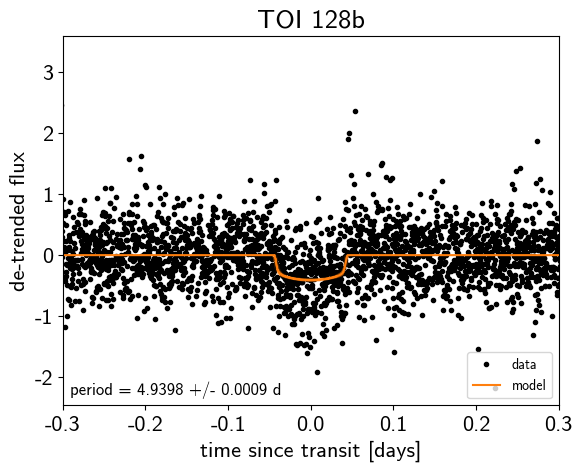

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

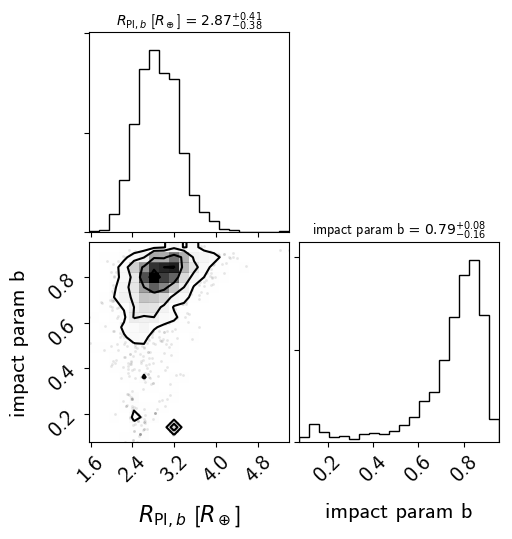

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

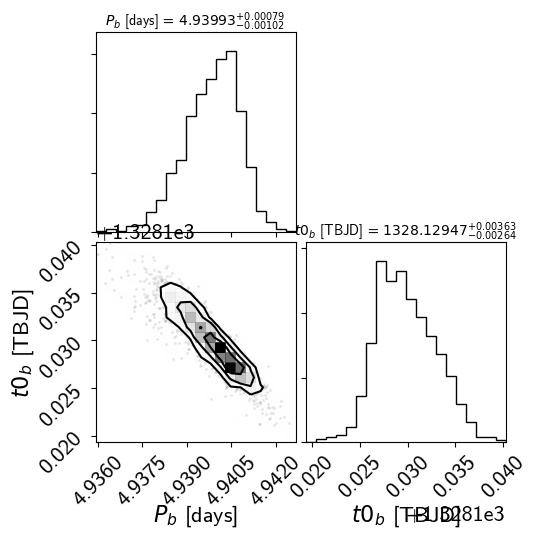

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

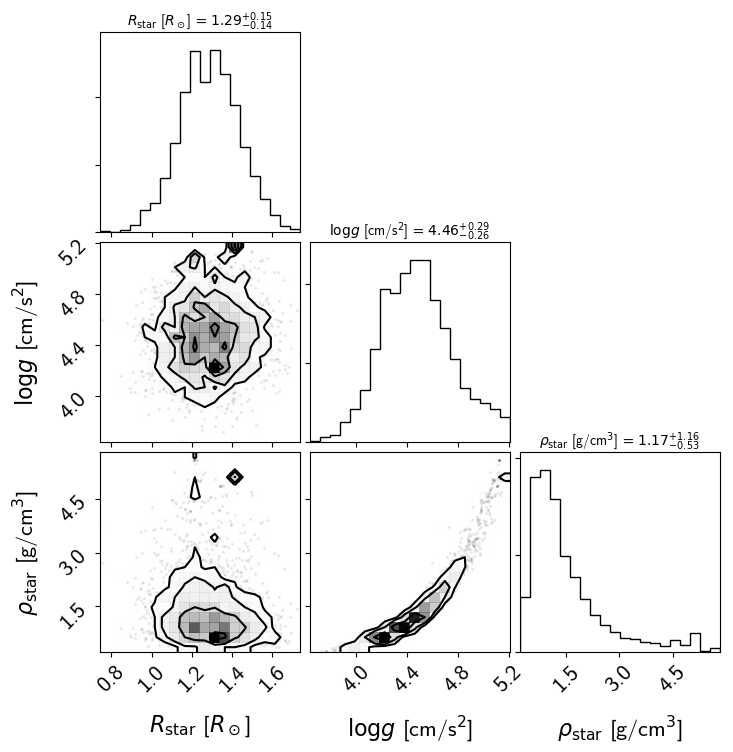

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3